In [41]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

# Enable multiple cell outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [178]:
#%matplotlib widget
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.patches import Patch
import pandas as pd
import numpy as np
from Color import *
from operator import truediv

# Matplotlib font configuration
from MatplotlibFonts import *

# Change the font size
rcParams.update({"font.size": 15})

In [3]:
RESULT_DIR='../icemu/log/'

In [172]:
# Benchmarks in order
Benchmarks = [
    'coremark',
    'sha',
    'crc',
    'aes',
    'dijkstra',
    'picojpeg'
]

# Configurations in order
Configurations = [
    'nacho-naive',
    'nacho-pw',
    'nacho-clank',
    'prowl'
]

Stats = [
    'checkpoints','cycle count','last checkpoint','dirty ratio','cause'
]

CacheConfig = [ "-512-2-", "-256-2-", "-1024-2-"]

FinalStats = [
    'cache_miss', 
    'cache_hit', 
    'cache_read', 
    'cache_write', 
    'cache_cuckoo', 
    'cache_checkpoint', 
    'nvm_reads_no_cache', 
    'nvm_writes_no_cache', 
    'nvm_reads', 
    'nvm_writes', 
    'checkpoint', 
    'checkpoint_war', 
    'checkpoint_dirty', 
    'checkpoint_period', 
    'checkpoint_max_cycles', 
    'hints_given', 
    'max_dirty_ratio', 
    'cuckoo_iter'
]

from BenchmarkConfiguration import *

In [6]:
df = {}
df['nacho-naive'] = {}
df['nacho-naive']['aes'] = pd.read_csv(RESULT_DIR + "aes" + "-nacho-clank" + CacheConfig[0] + "cont").set_index("checkpoints")
df['nacho-naive']['aes']

,cycle count,last checkpoint,dirty ratio,cause
checkpoints,,,,
1,2909,2909,0.359375,0
2,6970,4061,0.117188,0
3,7086,116,0.031250,0
4,7125,39,0.031250,0
5,7164,39,0.031250,0
...,...,...,...,...
146,199740,133,0.031250,0
147,199778,38,0.031250,0
148,199816,38,0.031250,0


In [19]:
# Load the benchmarks
def load_cont_stats(bench, config, cache):
    file = RESULT_DIR + bench + "-" + config + cache
    return pd.read_csv(file + "cont").set_index("checkpoints")

def load_final_stats(bench, config, cache):
    file = RESULT_DIR + bench + "-" + config + cache
    return dict(pd.read_csv(file + "final", delimiter=":", header = None).values)

cont_stats = {}
final_stats = {}
for cache in CacheConfig:
    cont_stats[cache] = {}
    final_stats[cache] = {}
    for config in Configurations:
        cont_stats[cache][config] = {}
        final_stats[cache][config] = {}
        for bench in Benchmarks:
            cont_stats[cache][config][bench] = load_cont_stats(bench, config, cache)
            final_stats[cache][config][bench] = load_final_stats(bench, config, cache)

In [22]:
final_stats['-512-2-']['prowl']['sha']


{'cache_miss': 1175074.0,
 'cache_hit': 2441574.0,
 'cache_read': 6976880.0,
 'cache_write': 2711065.0,
 'cache_cuckoo': 8551459.0,
 'cache_checkpoint': 2595580.0,
 'nvm_reads_no_cache': 8012757.0,
 'nvm_writes_no_cache': 2711065.0,
 'nvm_reads': 1035877.0,
 'nvm_writes': 2622922.0,
 'checkpoint': 12803.0,
 'checkpoint_war': 12768.0,
 'checkpoint_dirty': 0.0,
 'checkpoint_period': 35.0,
 'checkpoint_max_cycles': 1000504.0,
 'hints_given': 0.0,
 'max_dirty_ratio': 0.882812,
 'cuckoo_iter': 1907455.0}

In [275]:
from Color import *

X = np.arange(len(Benchmarks))
step_size = 1 / (len(Configurations) + 1) 

cache_config_used = None

def fetchNormalizingFactor(bmark, requested_stats):
    normalizing_factor = []
    for b in final_stats[cache_config_used][bmark]:
        val = 0
        for e in requested_stats:
            val = val + final_stats[cache_config_used][bmark][b][e]
        
        normalizing_factor.append(val)

    return normalizing_factor


def plotStatPerBenchmark(ax, requested_stats, normalizing_bmark, title, mean_stat = "dirty_ratio"):
    step = 0.00
    idx_work = 0
    put_a_x = 0
    
    ax.set_ylabel('Normalized ratio')
    ax.set_title(title + ' normalized to ' + normalizing_bmark)

    normalize = fetchNormalizingFactor(normalizing_bmark, requested_stats)
    
    # For each work
    for works in final_stats[cache_config_used]:        
        to_plot = np.zeros(len(Benchmarks))
        idx_stat = 0
        
        # For each stack in the bar plot - stats
        for stats in requested_stats:
#             print("For " + str(stats))
            curr_stats = []
            
            # For each bmark
            for bmarks in final_stats[cache_config_used][works]:
                curr_stats.append(final_stats[cache_config_used][works][bmarks][stats])
                
            # Normalize the stats
            curr_stats = list(map(truediv, curr_stats, normalize))
            
            # plot the stacked bar
            line = ax.bar(X + step,
                           curr_stats,
                           bottom = to_plot,
                           linewidth = 1,
                           joinstyle = 'miter',
                        #    hatch = patterns[idx_stat],
                        #    color = Color[list(Color.keys())[idx_stat]],
                           color = StackedBarColors[idx_work][3 - idx_stat],
                           alpha = 1 - 0.15 * idx_stat,
                           edgecolor = 'white',
                           width = 4.5 * step_size / 5)
            
            # increment the stack
            to_plot = to_plot + curr_stats

            # N colors for N stats
            idx_stat = idx_stat + 1
            # print(idx_stat)
        
        s = 0
        for i in to_plot:
            if (i == 0):
                ax.text(s, 0, "x",
                        color = Color['red'],
                        fontsize = 'x-large')
            s = s + 1
        
        # Three colors for 3 works
        idx_work = idx_work + 1
        # print(idx_work)

        # Separating each bmark
        step = step + step_size

In [276]:
def plotAvgLineAndLegend(ax, line_data=None):
    if (line_data is not None):
        for work in final_stats[cache_config_used]:
            points = []
            points_max = []
            for bmark in cont_stats[cache_config_used][work]:
                sum_val = np.asarray(cont_stats[cache_config_used][work][bmark][line_data].values).sum()
                if sum_val == 0:
                    points.append(0)
                    points_max.append(1)
                    continue
                avg_val = np.asarray(cont_stats[cache_config_used][work][bmark][line_data].values).mean()
                max_val = np.asarray(cont_stats[cache_config_used][work][bmark][line_data].values).max()
                points.append(avg_val)
                points_max.append(max_val)
                
            points = list(map(truediv, points, points_max))

            ax.plot(X + step_size, points, '-o', label=work + '\navg ' + line_data)

# 512Kb cache for different stats

(-0.25, 5.85)

(-0.25, 5.85)

(-0.25, 5.85)

Text(60.3029478080246, 0.5, 'Normalized ')

Text(0.5, 1.0, 'test')

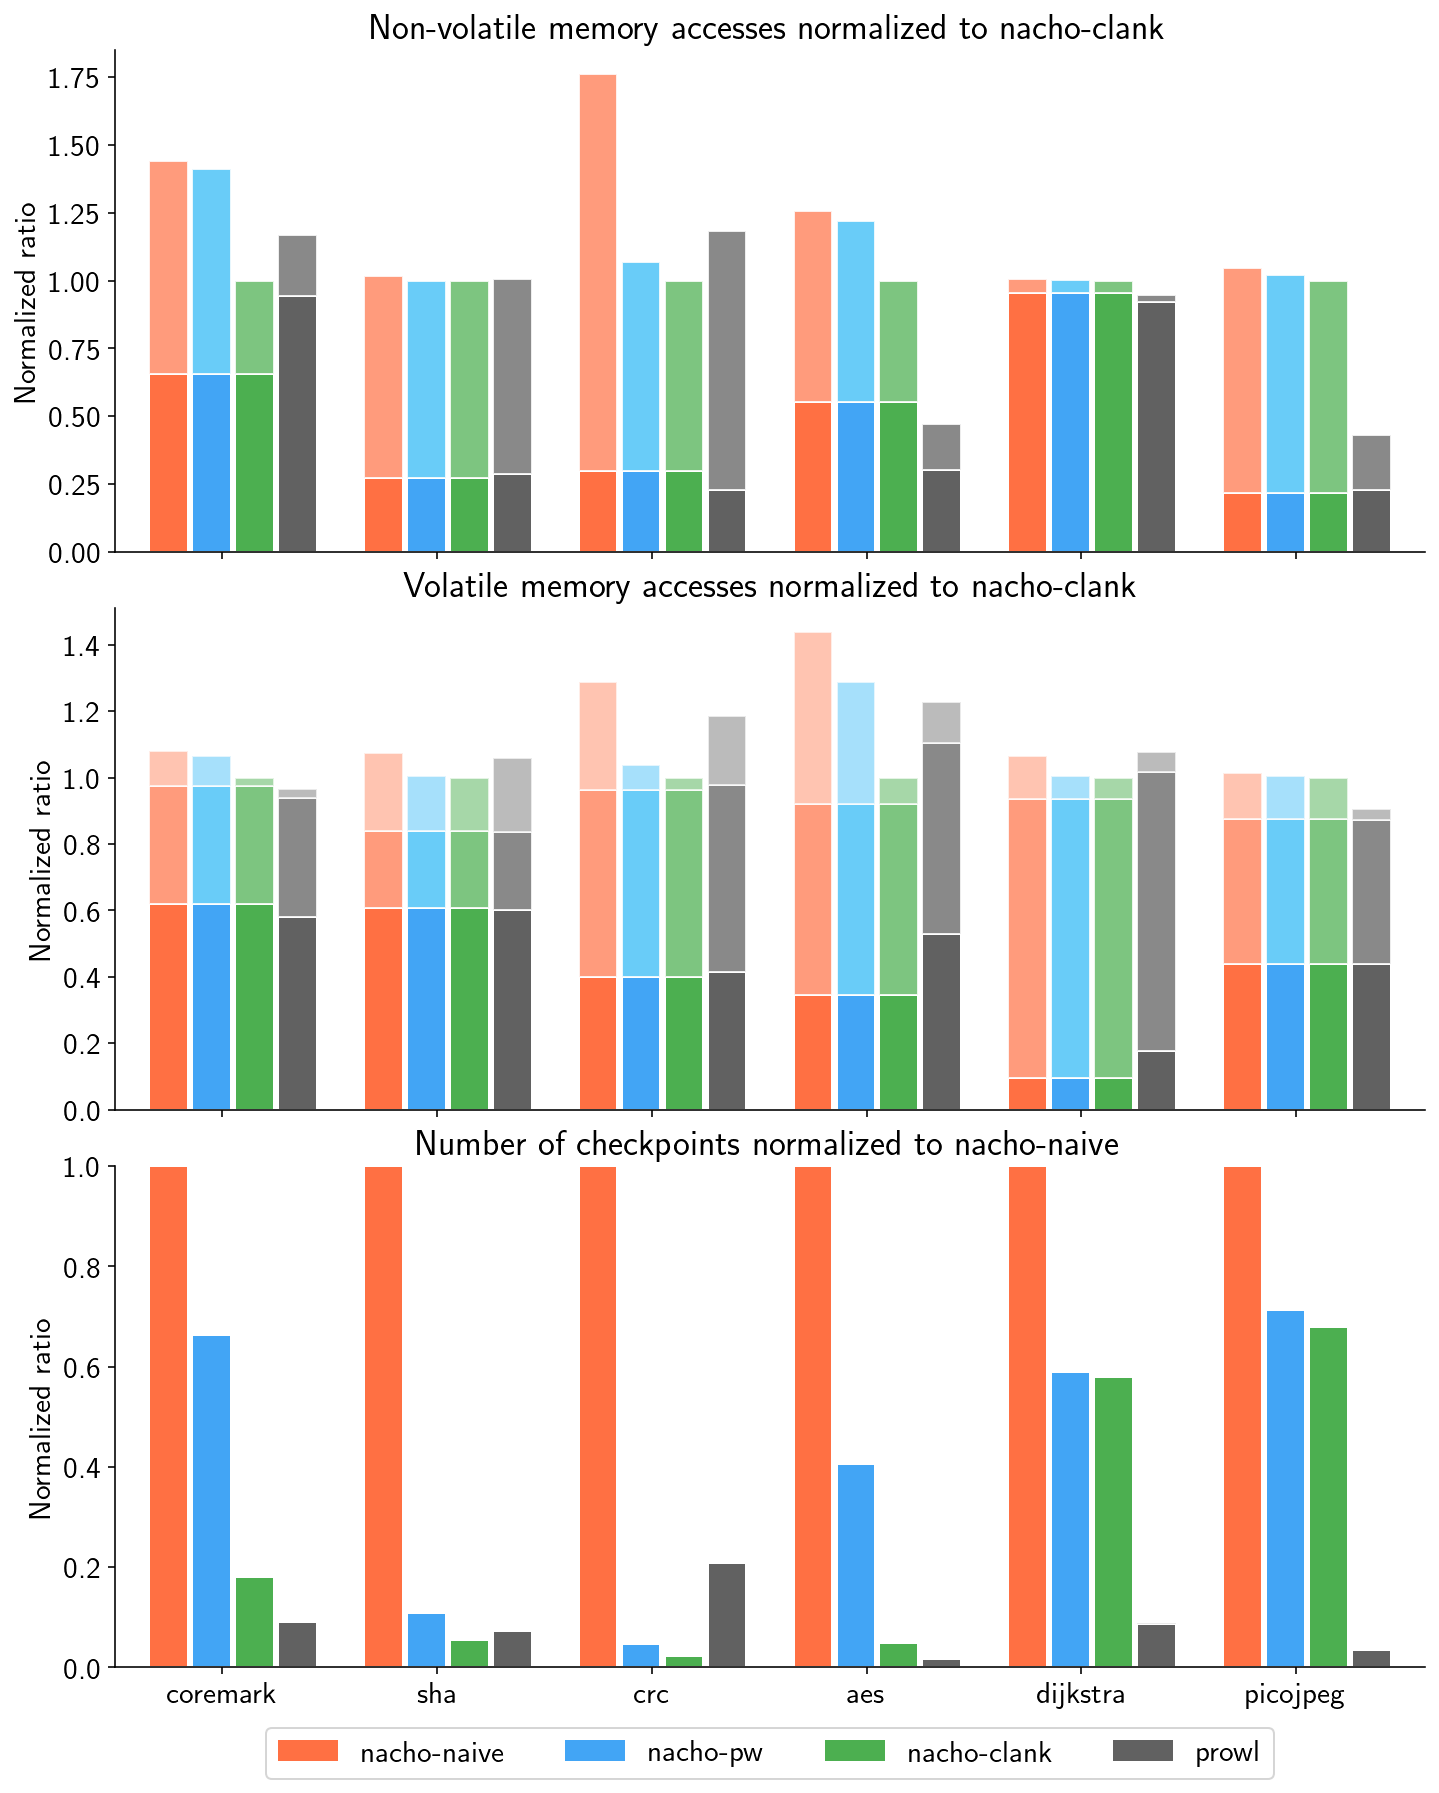

In [277]:
cache_config_used = "-512-2-"
fig, ax = plt.subplots(nrows=3, ncols=1, sharex=True, figsize=(10,12));
fig.tight_layout(pad=1);

for a in ax:
    # a.set_ylim(bottom=0, top=1.8)
    a.set_xlim(-0.25,5.85)
    a.margins(x=0)
    a.spines['right'].set_visible(False)
    a.spines['top'].set_visible(False)

ax[0].set_xticks(X + 0.25, Benchmarks);

ax[0].set_ylabel('Normalized ');
ax[0].set_title('test');


plotStatPerBenchmark(ax[0], ['nvm_reads', 'nvm_writes'],
                     'nacho-clank',
                     "Non-volatile memory accesses");

plotStatPerBenchmark(ax[1], ['cache_read', 
                      'cache_write',
                      'cache_checkpoint'], 'nacho-clank',
                      'Volatile memory accesses');

plotStatPerBenchmark(ax[2], ['checkpoint_war', 
                      'checkpoint_dirty', 
                      'checkpoint_period',], 'nacho-naive',
                      'Number of checkpoints')

# Add invisible data to add another legend
n=[]
h,l = ax[1].get_legend_handles_labels()
labels = Configurations

for i in range(len(Benchmarks)):
    n.append(ax[1].bar(0, 0, color=StackedBarColors[i][3]))

# l1 = axTop.legend(h[:len(Benchmarks)], l[:len(Benchmarks)],
#             bbox_to_anchor=(0., -0.222, 1., .102), 
#             loc='center right',
#             ncol=3,
#             borderaxespad=0., mode="expand")

if labels is not None:
    l2 = plt.legend(n, labels, bbox_to_anchor=(0., -0.222, 1., .102), 
            loc='center',
            ncol=4) 
# axTop.add_artist(l2)

# Stats for different caches

(0.0, 1.0)

(-0.25, 5.85)

(0.0, 1.0)

(-0.25, 5.85)

(0.0, 1.0)

(-0.25, 5.85)

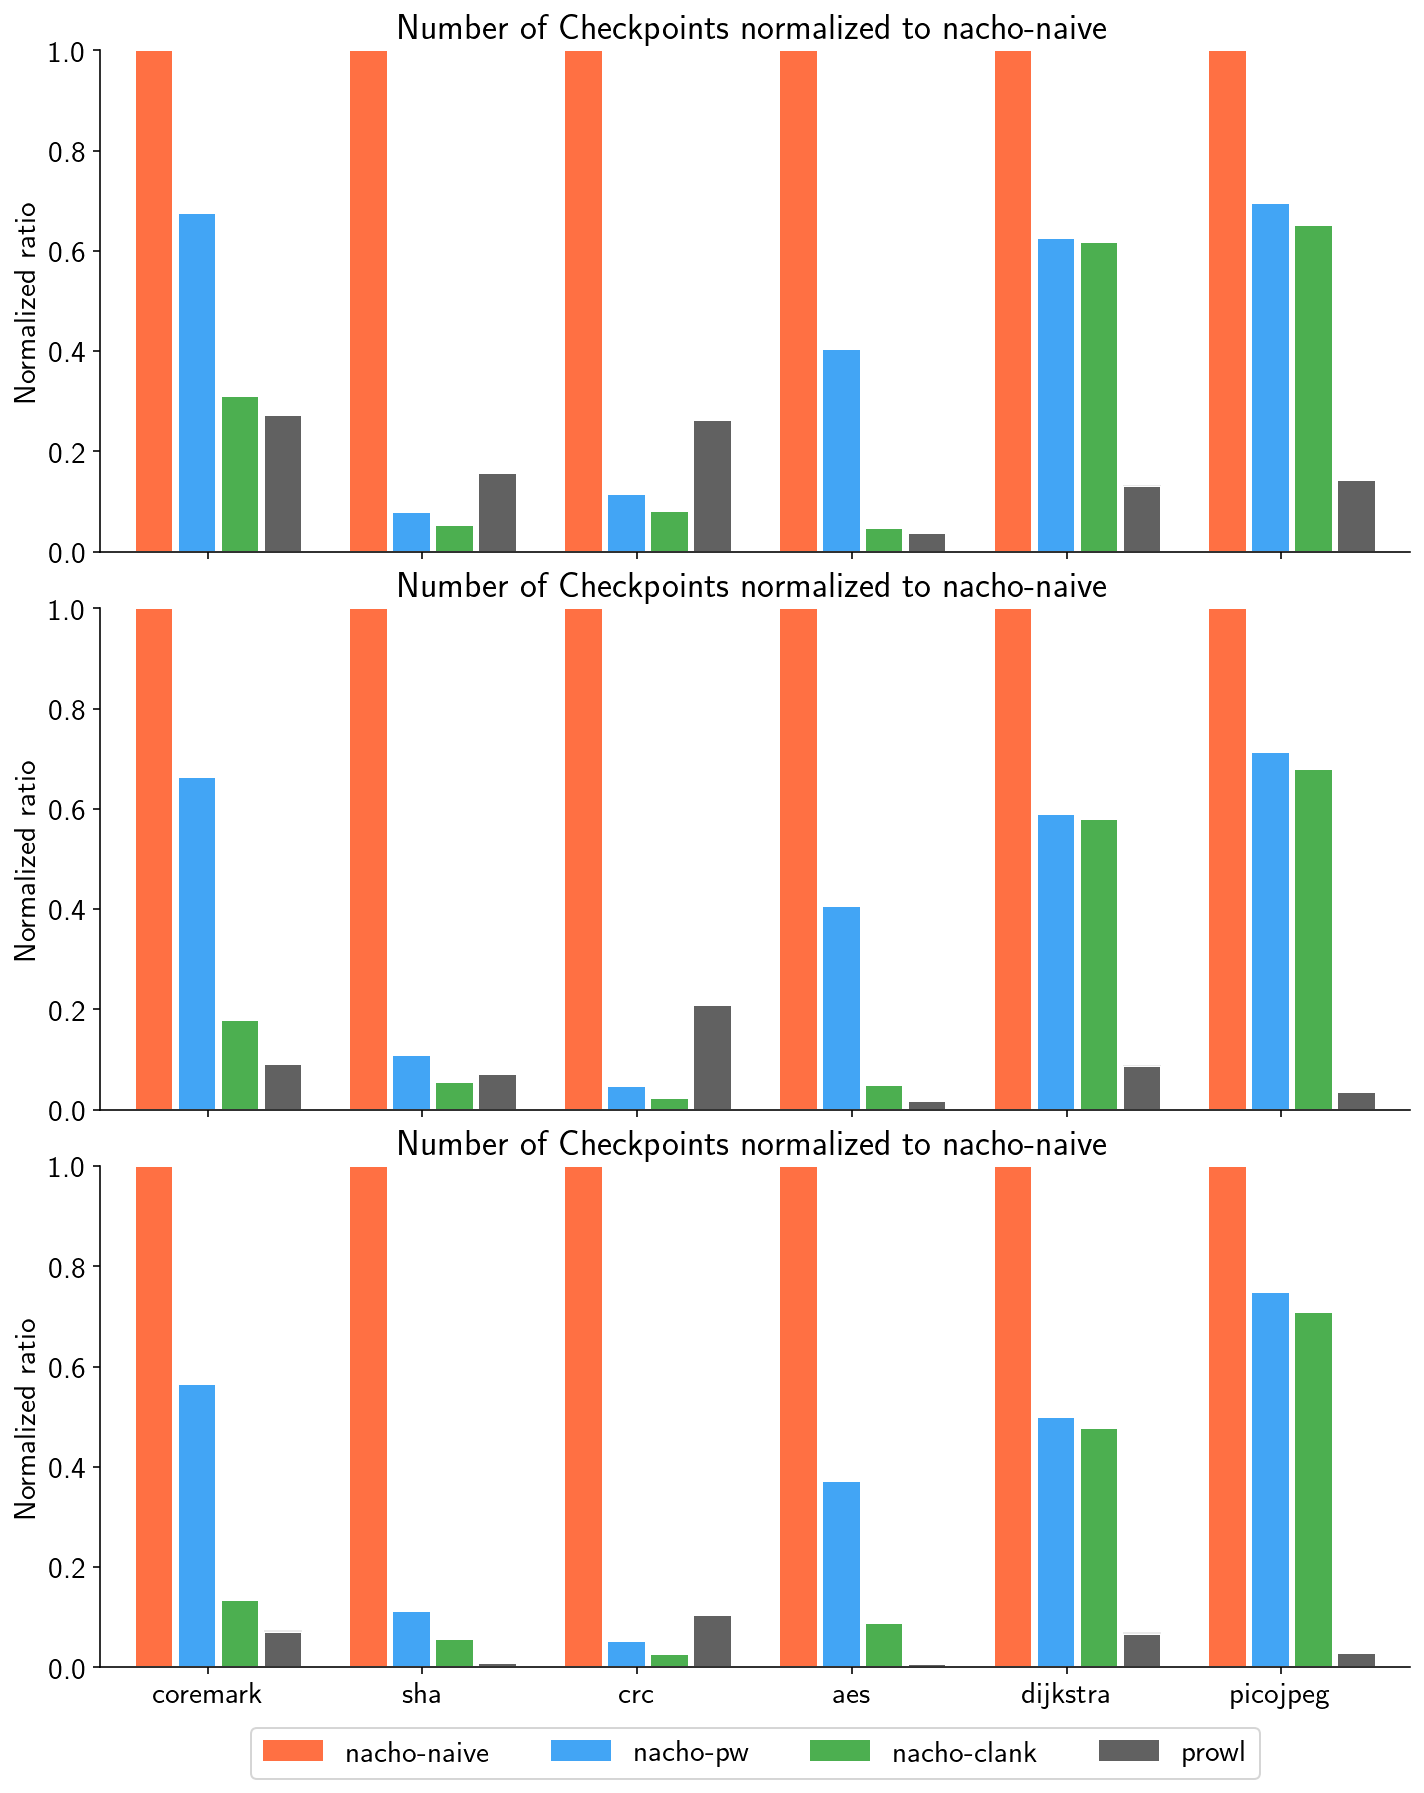

In [325]:

fig, ax = plt.subplots(nrows=3, ncols=1, sharex=True, figsize=(10,12));
fig.tight_layout(pad=1);
ylegend = 1.0
for a in ax:
    a.set_ylim(auto=True)
    a.set_xlim(-0.25,5.85);
    a.margins(x=0);
    a.spines['right'].set_visible(False);
    a.spines['top'].set_visible(False);

ax[0].set_xticks(X + 0.25, Benchmarks);
isCheckpoints = False

# Uncomment/change what stats which are needed to be plotted
# stats_plotted = ['cache_read', 'cache_write', 'cache_checkpoint']
# stats_desc = ['read', 'write', 'checkpoint']
# title = 'Volatile memory accesses'
# normalizationBmark = "nacho-naive"

# stats_plotted = ['nvm_reads', 'nvm_writes']
# stats_desc = ['reads', 'writes']
# title = 'Non volatile memory access'
# normalizationBmark = "nacho-naive"

stats_plotted = ['checkpoint_war', 'checkpoint_dirty', 'checkpoint_period']
stats_desc = ['WAR', 'ditry ratio', 'period']
title = 'Number of Checkpoints'
normalizationBmark = "nacho-naive"
isCheckpoints = True

# Do the actual plotting
cache_config_used = "-256-2-"
plotStatPerBenchmark(ax[0], stats_plotted, normalizationBmark, title);

cache_config_used = "-512-2-"
plotStatPerBenchmark(ax[1], stats_plotted, normalizationBmark, title);

cache_config_used = "-1024-2-"
plotStatPerBenchmark(ax[2], stats_plotted, normalizationBmark, title);

# For the legend
n=[];
h,l = ax[1].get_legend_handles_labels();
labels = Configurations;

for i in range(len(Benchmarks)):
    n.append(ax[1].bar(0, 0, color=StackedBarColors[i][3]));

if labels is not None:
    l2 = plt.legend(n, labels, bbox_to_anchor=(0., -0.222, 1., .102), 
            loc='center',
            ncol=4);
# axTop.add_artist(l2)

if isCheckpoints is not True:
    # Add a manual legend for the stats
    for a in ax:
        ybase = ylegend
        idx = 0
        xbase = 4.75
        a.add_patch(Rectangle((xbase-0.08, ybase-0.08), 1, 0.1 * len(stats_desc) + 0.2, fill=False));
        for e in stats_plotted:
            statsLegend = a.add_patch(Rectangle((xbase, ybase), 0.2, 0.05));
            statsLegend.set(color=StackedBarColors[3][3 - idx], alpha=1 - 0.15 * idx);
            a.text(xbase + 0.25, ybase, stats_desc[idx], fontsize='small');
            ybase = ybase + 0.1;
            idx = idx + 1;
        a.text(xbase, ybase+0.02, "Accesses during a", fontsize='small');

(0.0, 1.0)

(-0.25, 5.85)

(0.0, 1.0)

(-0.25, 5.85)

(0.0, 1.0)

(-0.25, 5.85)

[None, None]

Text(5.0, 1.2, 'read')

[None, None]

Text(5.0, 1.3, 'write')

[None, None]

Text(5.0, 1.4000000000000001, 'checkpoint')

Text(4.75, 1.5200000000000002, 'Accesses during a')

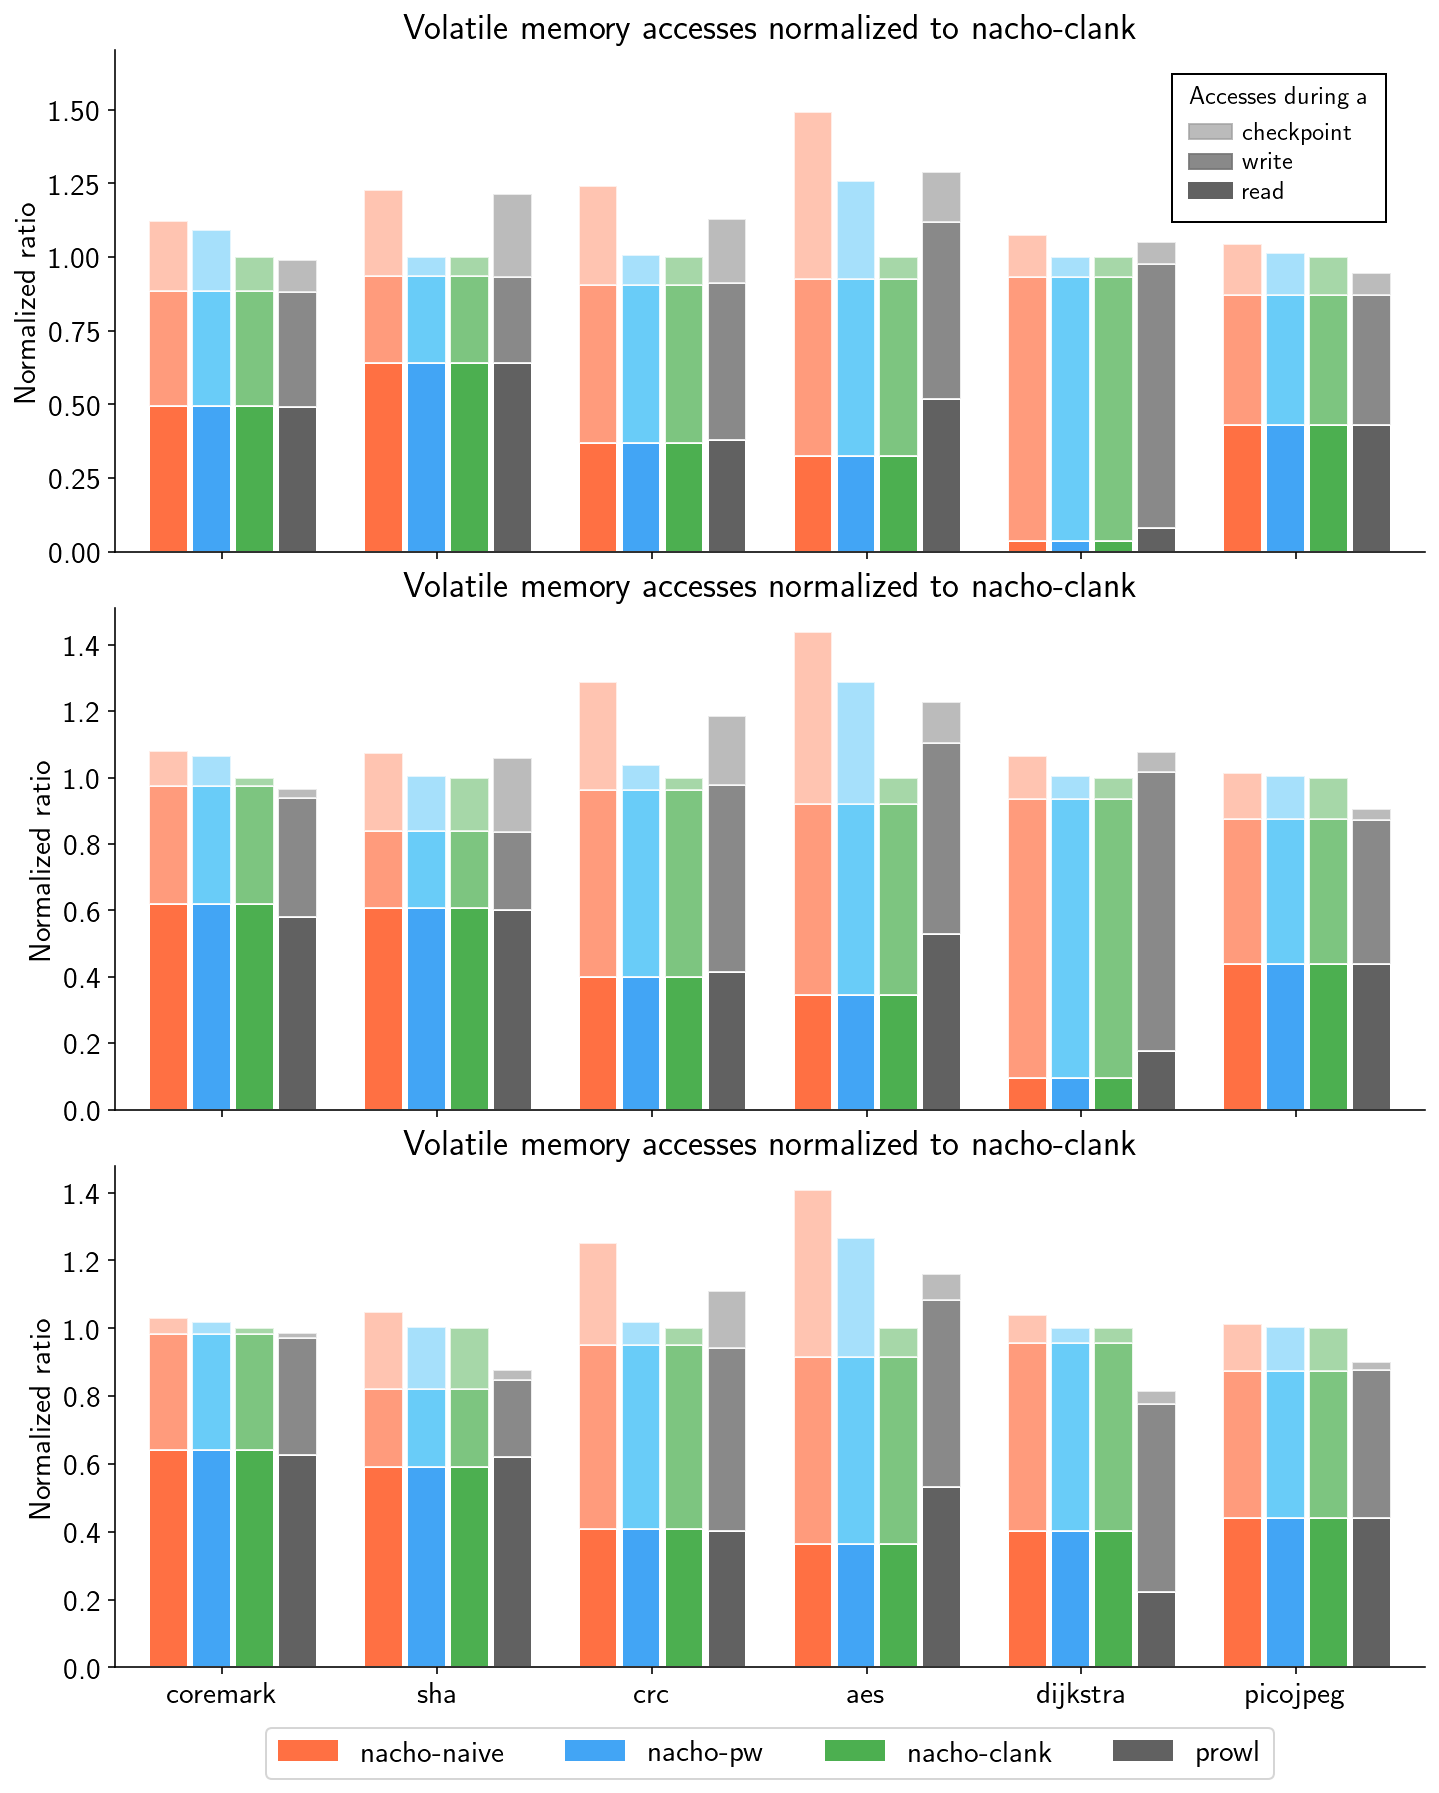

In [328]:

fig, ax = plt.subplots(nrows=3, ncols=1, sharex=True, figsize=(10,12));
fig.tight_layout(pad=1);
ylegend = 1.2
for a in ax:
    a.set_ylim(auto=True)
    a.set_xlim(-0.25,5.85);
    a.margins(x=0);
    a.spines['right'].set_visible(False);
    a.spines['top'].set_visible(False);

ax[0].set_xticks(X + 0.25, Benchmarks);
isCheckpoints = False

# Uncomment/change what stats which are needed to be plotted
stats_plotted = ['cache_read', 'cache_write', 'cache_checkpoint']
stats_desc = ['read', 'write', 'checkpoint']
title = 'Volatile memory accesses'
normalizationBmark = "nacho-clank"

# stats_plotted = ['nvm_reads', 'nvm_writes']
# stats_desc = ['reads', 'writes']
# title = 'Non volatile memory access'
# normalizationBmark = "nacho-naive"

# stats_plotted = ['checkpoint_war', 'checkpoint_dirty', 'checkpoint_period']
# stats_desc = ['WAR', 'ditry ratio', 'period']
# title = 'Number of Checkpoints'
# normalizationBmark = "nacho-naive"
# isCheckpoints = True

# Do the actual plotting
cache_config_used = "-256-2-"
plotStatPerBenchmark(ax[0], stats_plotted, normalizationBmark, title);

cache_config_used = "-512-2-"
plotStatPerBenchmark(ax[1], stats_plotted, normalizationBmark, title);

cache_config_used = "-1024-2-"
plotStatPerBenchmark(ax[2], stats_plotted, normalizationBmark, title);

# For the legend
n=[];
h,l = ax[1].get_legend_handles_labels();
labels = Configurations;

for i in range(len(Benchmarks)):
    n.append(ax[1].bar(0, 0, color=StackedBarColors[i][3]));

if labels is not None:
    l2 = plt.legend(n, labels, bbox_to_anchor=(0., -0.222, 1., .102), 
            loc='center',
            ncol=4);
# axTop.add_artist(l2)

if isCheckpoints is not True:
    # Add a manual legend for the stats
    for a in ax[0:1]:
        ybase = ylegend
        idx = 0
        xbase = 4.75
        a.add_patch(Rectangle((xbase-0.08, ybase-0.08), 1, 0.1 * len(stats_desc) + 0.2, fill=False));
        for e in stats_plotted:
            statsLegend = a.add_patch(Rectangle((xbase, ybase), 0.2, 0.05));
            statsLegend.set(color=StackedBarColors[3][3 - idx], alpha=1 - 0.15 * idx);
            a.text(xbase + 0.25, ybase, stats_desc[idx], fontsize='small');
            ybase = ybase + 0.1;
            idx = idx + 1;
        a.text(xbase, ybase+0.02, "Accesses during a", fontsize='small');

In [ ]:
#df['sha'] = df['sha'].reindex(ConfigurationNameMap)
df['nacho']['aes'].reindex(ConfigurationNameMap)

In [ ]:
dfa = pd.DataFrame()
for bench in Benchmarks:
    dfa[BenchmarkNameMap[bench]] = df[bench].reindex(ConfigurationNameMap)['Execution']
    
dfa.rename(index=ConfigurationNameMap, inplace=True)
dfa

In [ ]:
mean_ratchet = dfa.T[ConfigurationNameMap['opt-ratchet']].mean()
mean_baseline = dfa.T[ConfigurationNameMap['opt-baseline']].mean()
mean_opt_all = dfa.T[ConfigurationNameMap['opt-all-expander']].mean()

In [ ]:
from statistics import mean

color_list = [ConfigurationColorMap[c] for c in Configurations]

bars = dfa.T.plot(kind='bar', ylim=(0,None), figsize=(13,2.9), color=color_list, edgecolor='white', linewidth=1)
plt.xticks(rotation=0)

handles, labels = bars.get_legend_handles_labels()

# Average for Ratchet and Opt-All
mean_ratchet_line = plt.axhline(y = mean_ratchet, color = ConfigurationColorMap['opt-ratchet'], 
                                linestyle = ':', label='Ratchet avg.')
mean_baseline_line = plt.axhline(y = mean_baseline, color = ConfigurationColorMap['opt-baseline'],
                                 linestyle = '--', label='R-PDG avg.')
mean_opt_all_line = plt.axhline(y = mean_opt_all, color = ConfigurationColorMap['opt-all-expander'],
                                linestyle = '--',label=r'\textbf{WARio} avg.')

# Add a line for the uninstrumented version (at 1)
plain_c_line = plt.axhline(y = 1, color =  Color['darkgrey'],
                                linestyle = '--',label=r'Uninstrumented C')

# Manually place the average lines at the end of the legend
handles.extend([mean_ratchet_line, mean_baseline_line, mean_opt_all_line, plain_c_line])

ratchet_bar_label_values = []
baseline_bar_label_values = []

# Iterate through the benchmarks (in order)
for idx, bench in enumerate(Benchmarks):
    # Skip some benchmark(s)
    skip = ['dijkstra']
    if bench in skip:
        continue
        
    overhead_ratchet_perc = df[bench]['Overhead-ratchet-%']['opt-all-expander']
    overhead_baseline_perc = df[bench]['Overhead-baseline-%']['opt-all-expander']
    execution_value = df[bench]['Execution']['opt-all-expander']
    
    def add_bar_label(text, text_loc, textcolor='black', facecolor='white', edgecolor='black', fontsize=11, draw_arrow=False):
        if draw_arrow == True:
            arrowprops = dict(arrowstyle='-|>', fc='black', connectionstyle='angle,angleA=0,angleB=90,rad=3')
        else:
            arrowprops = None
        
        plt.annotate(text, xy=(idx+0.225, execution_value), xytext=text_loc,
            color=textcolor,
            xycoords=('data'), textcoords='offset points', fontsize=fontsize,
            horizontalalignment='right', verticalalignment='center',
            bbox=dict(facecolor=facecolor, linewidth='1', edgecolor=edgecolor),
            arrowprops=arrowprops,
        )
        
    add_bar_label('{:02.1f}\%'.format(overhead_ratchet_perc),
                  text_loc=(50,32),
                  fontsize=11,
                  textcolor='white',
                  edgecolor=ConfigurationColorMap['opt-ratchet'],
                  facecolor=ConfigurationColorMap['opt-ratchet'],
                  draw_arrow=False)
    add_bar_label('\\textbf{'+'{:02.1f}\%'.format(overhead_baseline_perc)+'}',
                  text_loc=(50, 18),
                  fontsize=12,
                  edgecolor=ConfigurationColorMap['opt-baseline'],
                  facecolor=ConfigurationColorMap['opt-baseline'],
                  draw_arrow=True)
    
    ratchet_bar_label_values.append(overhead_ratchet_perc)
    baseline_bar_label_values.append(overhead_baseline_perc)
    

# Annotate the average lines
# Transformations
plt.annotate('', xy=(4.6, mean_opt_all-0.1), xytext=(4.6,mean_baseline+0.1),
             arrowprops=dict(arrowstyle='<|-|>', fc='black'))
reduction_perc = (mean_baseline-mean_opt_all)/mean_baseline * 100
plt.annotate('-{:02.1f}\%'.format(reduction_perc), xy=(4.6, mean_opt_all+(mean_baseline-mean_opt_all)/2), 
             xytext=(-5,-2), textcoords='offset points',
             fontsize=12,
             horizontalalignment='right', verticalalignment='center')


# PDG
plt.annotate('', xy=(4.6, mean_baseline-0.1), xytext=(4.6,mean_ratchet+0.1),
             arrowprops=dict(arrowstyle='<|-|>', fc='darkgrey', edgecolor='darkgrey'))
reduction_perc = (mean_ratchet-mean_baseline)/mean_ratchet * 100
plt.annotate('-{:02.1f}\%'.format(reduction_perc), xy=(4.6, mean_baseline+(mean_ratchet-mean_baseline)/2), 
             xytext=(-5,0), textcoords='offset points',
             fontsize=12,
             horizontalalignment='right', verticalalignment='center')

# Combined
plt.annotate('', xy=(4.15, mean_opt_all-0.1), xytext=(4.15,mean_ratchet+0.1),
             arrowprops=dict(arrowstyle='<|-|>', fc='black'))
reduction_perc = (mean_ratchet-mean_opt_all)/mean_ratchet * 100
plt.annotate('\\textbf{'+'-{:02.1f}\%'.format(reduction_perc)+'}', xy=(4.15, mean_opt_all+(mean_ratchet-mean_opt_all)/2), 
             xytext=(-5,-2), textcoords='offset points',
             fontsize=12,
             horizontalalignment='right', verticalalignment='center')

#plt.subplots_adjust(right=1.3)
plt.xlim(-0.4, len(Benchmarks)-1+0.7)

# Add the legend
plt.legend(handles=handles, bbox_to_anchor=(0, 1.04, 1.18, 0), loc="upper right", fancybox=True, ncol=1, fontsize=10)

# Place a box arround the sub-components of the legend
rect = Rectangle( (5.74, 2.9), 1.02, 1.5, linewidth=1.1, linestyle='dashed', fill=None, clip_on=False, zorder=200, color=Color['blue'], alpha=0.9)
plt.gca().add_patch(rect)

# Add some rotated text on the box
plt.gca().text(6.76,3, r'\textbf{WARio}', color=Color['blue'], rotation=-90, fontsize=13, zorder=200)

# Add a second legend with the averages for the percent blocks
plt.annotate(r'\textbf{-xx.x\%}', xy=(0.1, 4.9), xytext=(0,0),
    color='white',
    xycoords=('data'), textcoords='offset points', fontsize=13,
    horizontalalignment='right', verticalalignment='center',
    bbox=dict(facecolor=ConfigurationColorMap['opt-ratchet'], edgecolor=ConfigurationColorMap['opt-ratchet'], linewidth='1'),
    arrowprops=None)
plt.annotate(r'checkpoint overhead compared to Ratchet', xy=(0.1, 4.9), xytext=(10,-0.8),
    color='black',
    xycoords=('data'), textcoords='offset points', fontsize=12,
    horizontalalignment='left', verticalalignment='center',
    bbox=dict(facecolor='white', edgecolor='white', linewidth='0'),
    arrowprops=None)
avg_ratchet = mean(ratchet_bar_label_values)
plt.annotate(r'\textbf{'+'-{:02.1f}\%'.format(avg_ratchet)+'} on average', xy=(1.07, 4.3), xytext=(0,0),
    color='black',
    xycoords=('data'), textcoords='offset points', fontsize=13,
    horizontalalignment='right', verticalalignment='center',
    bbox=dict(facecolor='white', edgecolor='white', linewidth='0'),
    arrowprops=None)

plt.annotate(r'\textbf{-yy.y\%}', xy=(2.9, 4.9), xytext=(0,0),
    color='black',
    xycoords=('data'), textcoords='offset points', fontsize=13,
    horizontalalignment='right', verticalalignment='center',
    bbox=dict(facecolor=ConfigurationColorMap['opt-baseline'], edgecolor=ConfigurationColorMap['opt-baseline'], linewidth='1'),
    arrowprops=None)
plt.annotate(r'checkpoint overhead compared to R-PDG', xy=(2.9, 4.9), xytext=(10,-0.8),
    color='black',
    xycoords=('data'), textcoords='offset points', fontsize=12,
    horizontalalignment='left', verticalalignment='center',
    bbox=dict(facecolor='white', edgecolor='white', linewidth='0'),
    arrowprops=None)
avg_baseline = mean(baseline_bar_label_values)
plt.annotate(r'\textbf{'+'-{:02.1f}\%'.format(avg_baseline)+'} on average', xy=(3.87, 4.3), xytext=(0,0),
    color='black',
    xycoords=('data'), textcoords='offset points', fontsize=13,
    horizontalalignment='right', verticalalignment='center',
    bbox=dict(facecolor='white', edgecolor='white', linewidth='0'),
    arrowprops=None)

# Increase the figure height just a bit
plt.gca().set_ylim(0, plt.gca().get_ylim()[1]+0.1)

# Set the axis
plt.ylabel('normalized execution time', fontsize=13)

# Show the plot
plt.tight_layout()
plt.show()


In [ ]:
# Save the figure
fig = bars.get_figure()
fig.savefig('plots/benchmark-comparison.pdf')

In [ ]:


# Create the checkpoint figure



In [ ]:
for bench in Benchmarks:
    #cps = df[bench]['Checkpoints']['opt-baseline']-1
    dfb = df[bench]
    cps = (dfb['IR-checkpoints']+dfb['Call-checkpoints']+dfb['Pop-checkpoints']+dfb['Spill-checkpoints'])['opt-baseline']
    dfb['IR-checkpoints-%'] =  dfb['IR-checkpoints']/cps*100
    dfb['Call-checkpoints-%'] =  dfb['Call-checkpoints']/cps*100
    dfb['Pop-checkpoints-%'] =  dfb['Pop-checkpoints']/cps*100
    dfb['Spill-checkpoints-%'] =  dfb['Spill-checkpoints']/cps*100

df['coremark']

In [ ]:
dfc = {}
plot = ['IR-checkpoints-%', 'Spill-checkpoints-%', 'Call-checkpoints-%', 'Pop-checkpoints-%']

for p in plot:
    dfc[p] = pd.DataFrame()
    for bench in Benchmarks:
        dfc[p][BenchmarkNameMap[bench]] = df[bench].reindex(Configurations)[p]
    
    dfc[p].rename(index=ConfigurationNameMap, inplace=True)
    dfc[p].drop('Ratchet', inplace=True)
    

dfc[plot[1]]

In [ ]:
from matplotlib.patches import Patch

ax = plt.figure(figsize=(13,2.7)).add_subplot(111)

cc = [ConfigurationColorMap[c] for c in Configurations[1:]]
labels = [ConfigurationNameMap[c] for c in Configurations[1:]]
width = 0.5
lw = 1.4

def patchwork(ax, hatch):
    for bar in ax.patches:
        if bar.get_hatch() == None: 
            bar.set_hatch(hatch)
            
def plot_bar(N):
    D = dfc[plot[0]]
    for n in range(1, N+1):
        D = D + dfc[plot[n]]
        
    D.T.plot(kind='bar', ax=ax, color=cc, width=width, edgecolor='white', legend=None, linewidth=lw)
    patchwork(ax, hatch_map[plot[N]])

hatch_map = {
    'IR-checkpoints-%': '',
    'Spill-checkpoints-%': 'xxx',
    'Call-checkpoints-%': '...',
    'Pop-checkpoints-%': '///'
}

# Plot the overlapping bars
plot_bar(3)
plot_bar(2)
plot_bar(1)
plot_bar(0)

# Plot the description of the crc benchmark
props = dict(boxstyle='round', facecolor=Color['cyan'], alpha=0.2)
text =  'almost no\nmiddle end\ncheckpoints\nto optimize'
plt.annotate(text, xy=(1.72, 2), xytext=(-32, 130),
        transform=ax.transAxes, textcoords='offset points', fontsize=11,
        horizontalalignment='center', verticalalignment='top',
        bbox=props,
        arrowprops=dict(arrowstyle='-|>', fc='black', connectionstyle='angle,angleA=90,angleB=-45,rad=5'),
)
props = dict(boxstyle='round', facecolor=Color['cyan'], alpha=0.2)
#text =  '\\textbf{many}\n\\textbf{middle end}\n\\textbf{checkpoints}\n\\textbf{optimized}\n\\textbf{away}'
text =  'many\nmiddle end\ncheckpoints\noptimized\naway'
plt.annotate(text, xy=(3.215, 8), xytext=(27, 122),
        transform=ax.transAxes, textcoords='offset points', fontsize=11,
        horizontalalignment='center', verticalalignment='top',
        bbox=props,
        arrowprops=dict(arrowstyle='-|>', fc='black', connectionstyle='angle,angleA=90,angleB=45,rad=5'),
)

plt.xticks(rotation=0)

handles = []
handles.append(Patch(label='middle end WARs (\%)', hatch=hatch_map['IR-checkpoints-%'],
                     facecolor='none', edgecolor='black', linewidth=lw))
handles.append(Patch(label='back end WARs (\%)', hatch=hatch_map['Spill-checkpoints-%'],
                     facecolor='none', edgecolor='black', linewidth=lw))
handles.append(Patch(label='function entry (\%)', hatch=hatch_map['Call-checkpoints-%'],
                     facecolor='none', edgecolor='black', linewidth=lw))
handles.append(Patch(label='function exit (\%)', hatch=hatch_map['Pop-checkpoints-%'],
                     facecolor='none', edgecolor='black', linewidth=lw))
handles.reverse()

for idx, l in enumerate(labels):
    handles.append(Patch(label=l, color=cc[idx]))

ax.legend(handles=handles, bbox_to_anchor=(0.018, 1.04, 1.17, 0), loc="upper right", ncol=1, fontsize=9.6)

# Place a box arround the sub-components of the legend
rect = Rectangle( (5.53, 22.3), 1.06, 30.5, linewidth=1.1, linestyle='dashed', fill=None, clip_on=False, zorder=200, color=Color['blue'], alpha=0.9)
plt.gca().add_patch(rect)

# Add some rotated text on the box
plt.gca().text(6.6,24, r'\textbf{WARio}', color=Color['blue'], rotation=-90, fontsize=13, zorder=200)

#plt.xlabel('benchmark')
plt.ylabel(r'checkpoint cause (\%)', fontsize=13)

plt.tight_layout()
plt.show()

In [ ]:
# Save the figure
fig = ax.get_figure()
fig.savefig('plots/benchmark-checkpoint-distribution.pdf')

In [ ]:
# 
# Create the table for the .elf sizes
#

In [ ]:
ColumnNames=[r'\textbf{Ratchet}', r'\textbf{WARio}', r'\textbf{WARio\,+\,\texttt{Expander}}']
avg_ratchet = 0.0
avg_wario = 0.0
avg_wario_exp = 0.0

tex=''
def tex_addl(t):
    global tex
    tex += t + '\n'
    
def tex_add(t):
    global tex
    tex += t

tex_addl(r'% table automatically generated by BenchmarkPlot.ipynb')
tex_addl(r'\begin{tabular}{@{}lrrr@{}}')
tex_addl(r'\toprule')

# One empty cell
# add the names of the configurations
for n in ColumnNames:
    tex_add(' & ' + n)
tex_addl(r' \\ \midrule')

# Add the benchmark columns
for bench in Benchmarks:
    # Get the numbers
    #print(bench)
    uninstr = df[bench].loc['uninstrumented']['ELF-size']
    ratchet = df[bench].loc['opt-ratchet']['ELF-size']
    wario = df[bench].loc['opt-all']['ELF-size']
    wario_exp = df[bench].loc['opt-all-expander']['ELF-size']
      
    ratchet = (ratchet-uninstr)/uninstr*100.0
    wario = (wario-uninstr)/uninstr*100.0
    wario_exp = (wario_exp-uninstr)/uninstr*100.0
    
    avg_ratchet += ratchet
    avg_wario += wario
    avg_wario_exp += wario_exp
    
    ratchet = '{:.1f}'.format(ratchet)
    wario = '{:.1f}'.format(wario)
    wario_exp = '{:.1f}'.format(wario_exp)
    
    tex_add(r'\textsf{'+BenchmarkNameMap[bench]+'}')
    tex_add(' & +'+ratchet+'\%')
    tex_add(' & +'+wario+'\%')
    tex_add(' & +'+wario_exp+'\%')
    tex_addl(r' \\')
    
tex_addl(r' \midrule')

# Add the average
tex_add(r'\emph{average}')

avg_ratchet = avg_ratchet/len(Benchmarks)
avg_wario = avg_wario/len(Benchmarks)
avg_wario_exp = avg_wario_exp/len(Benchmarks)

avg_ratchet = '{:.1f}'.format(avg_ratchet)
avg_wario = '{:.1f}'.format(avg_wario)
avg_wario_exp = '{:.1f}'.format(avg_wario_exp)

tex_add(' & +'+avg_ratchet+'\%')
tex_add(' & +'+avg_wario+'\%')
tex_add(' & +'+avg_wario_exp+'\%')
tex_addl(r' \\ \bottomrule')

# End the table
tex_addl(r'\end{tabular}')
    
print(tex)
# Save the table
with open('plots/elfsize-table.tex', "w") as f:
    # Writing data to a file
    f.write(tex)

In [ ]:
len(Benchmarks)

In [ ]:
# Create a table for the checkpoint + reduction

ColumnNames=[r'\textbf{WARio}', r'\textbf{WARio\,+\,\texttt{Expander}}']
avg_wario = 0.0
avg_wario_exp = 0.0

tex=''
def tex_addl(t):
    global tex
    tex += t + '\n'
    
def tex_add(t):
    global tex
    tex += t

tex_addl(r'% table automatically generated by BenchmarkPlot.ipynb')
tex_addl(r'\begin{tabular}{@{}lrr@{}}')
tex_addl(r'\toprule')

# One empty cell
# add the names of the configurations
for n in ColumnNames:
    tex_add(' & ' + n)
tex_addl(r' \\ \midrule')

# Add the benchmark columns
for bench in Benchmarks:
    # Get the numbers
    #print(bench)
    ratchet = df[bench].loc['opt-ratchet']['Checkpoints']
    wario = df[bench].loc['opt-all']['Checkpoints']
    wario_exp = df[bench].loc['opt-all-expander']['Checkpoints']
      
    wario = (wario-ratchet)/ratchet*100.0
    wario_exp = (wario_exp-ratchet)/ratchet*100.0
    
    avg_wario += wario
    avg_wario_exp += wario_exp
    
    wario = '{:.1f}'.format(wario)
    wario_exp = '{:.1f}'.format(wario_exp)
    
    tex_add(r'\textsf{'+BenchmarkNameMap[bench]+'}')
    tex_add(' & '+wario+'\%')
    tex_add(' & '+wario_exp+'\%')
    tex_addl(r' \\')
    
tex_addl(r' \midrule')

# Add the average
tex_add(r'\emph{average}')

avg_wario = avg_wario/len(Benchmarks)
avg_wario_exp = avg_wario_exp/len(Benchmarks)

avg_wario = '{:.1f}'.format(avg_wario)
avg_wario_exp = '{:.1f}'.format(avg_wario_exp)

tex_add(' & '+avg_wario+'\%')
tex_add(' & '+avg_wario_exp+'\%')
tex_addl(r' \\ \bottomrule')

# End the table
tex_addl(r'\end{tabular}')
    
print(tex)
# Save the table
with open('plots/executed-checkpoint-table.tex', "w") as f:
    # Writing data to a file
    f.write(tex)